<a href="https://colab.research.google.com/github/phdtrong/PortfolioProjects/blob/phdtrong-patch-main-portfolio/project10/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Library importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
#Training Setting
split_ratio = 0.5
stock = ['TSLA']

#Fetch the data - Select date range
import yfinance as yf
df = yf.download(stock, period='max')
df.reset_index(inplace=True)
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000


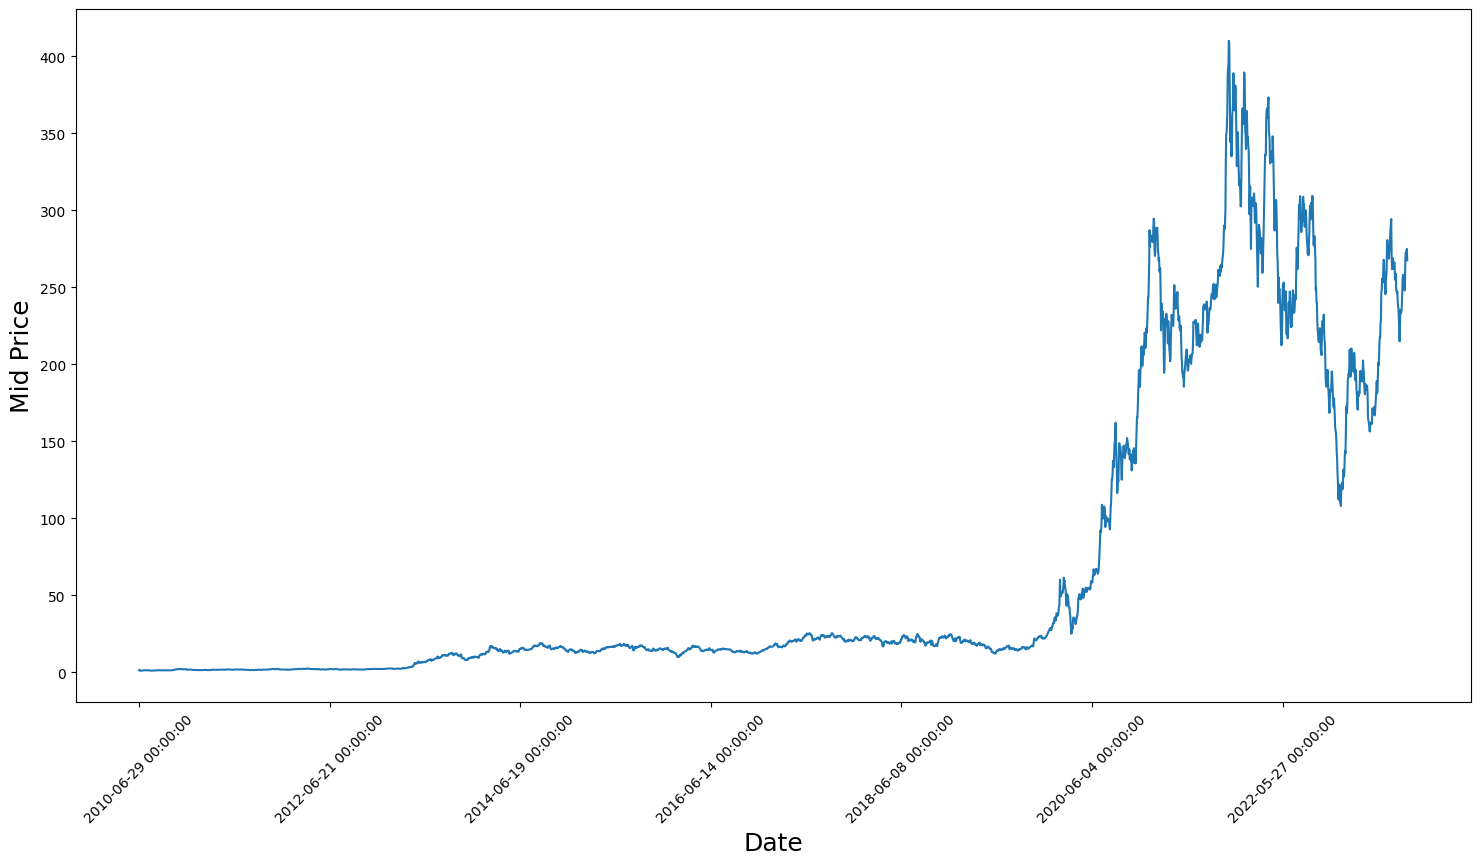

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [ ]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
mid_prices = (high_prices+low_prices)/2.0

In [ ]:
split_point = (int) (mid_prices.size/2) # (3328,)
#del train_data, test_data
train_data = mid_prices[:split_point]
test_data = mid_prices[split_point:]

In [ ]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_data = train_data.values.reshape(-1,1)  # if it is ndarray:convert ndarray to dataframe by [[]]
test_data = test_data.values.reshape(-1,1)  # if it is series: .values

In [ ]:
train_data

array([[ 1.41799998],
       [ 1.79066658],
       [ 1.53966653],
       ...,
       [16.67099953],
       [16.72866631],
       [16.94833374]])

In [ ]:
test_data

array([[ 17.21399975],
       [ 17.31866646],
       [ 17.91100025],
       ...,
       [273.56500244],
       [274.99000549],
       [267.6000061 ]])

In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = (int)(split_point/4)
for di in range(0,split_point,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
#scaler.fit(train_data[di+smoothing_window_size:,:])
#train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(split_point):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [ ]:
window_size = (int)(split_point/16)
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01998


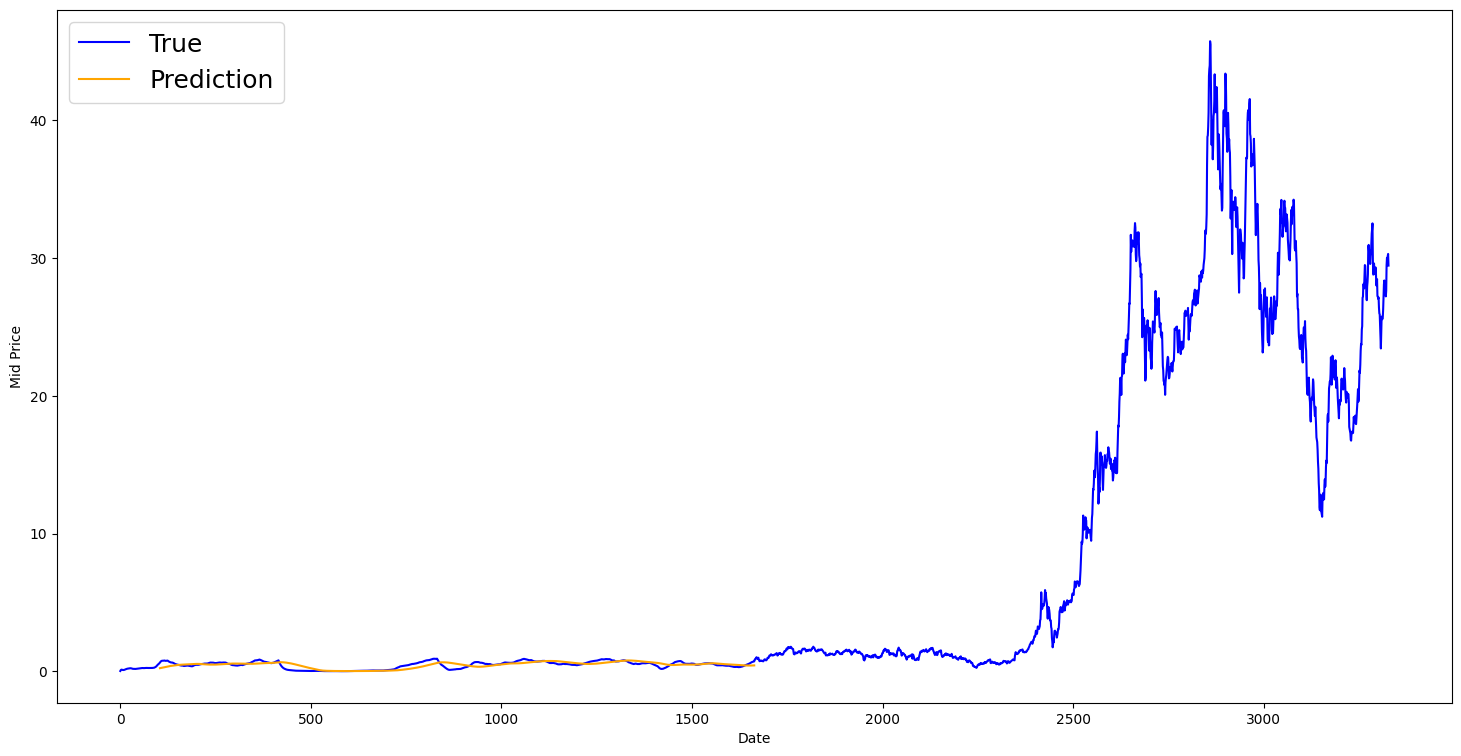

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
window_size = (int)(split_point/16)
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00018


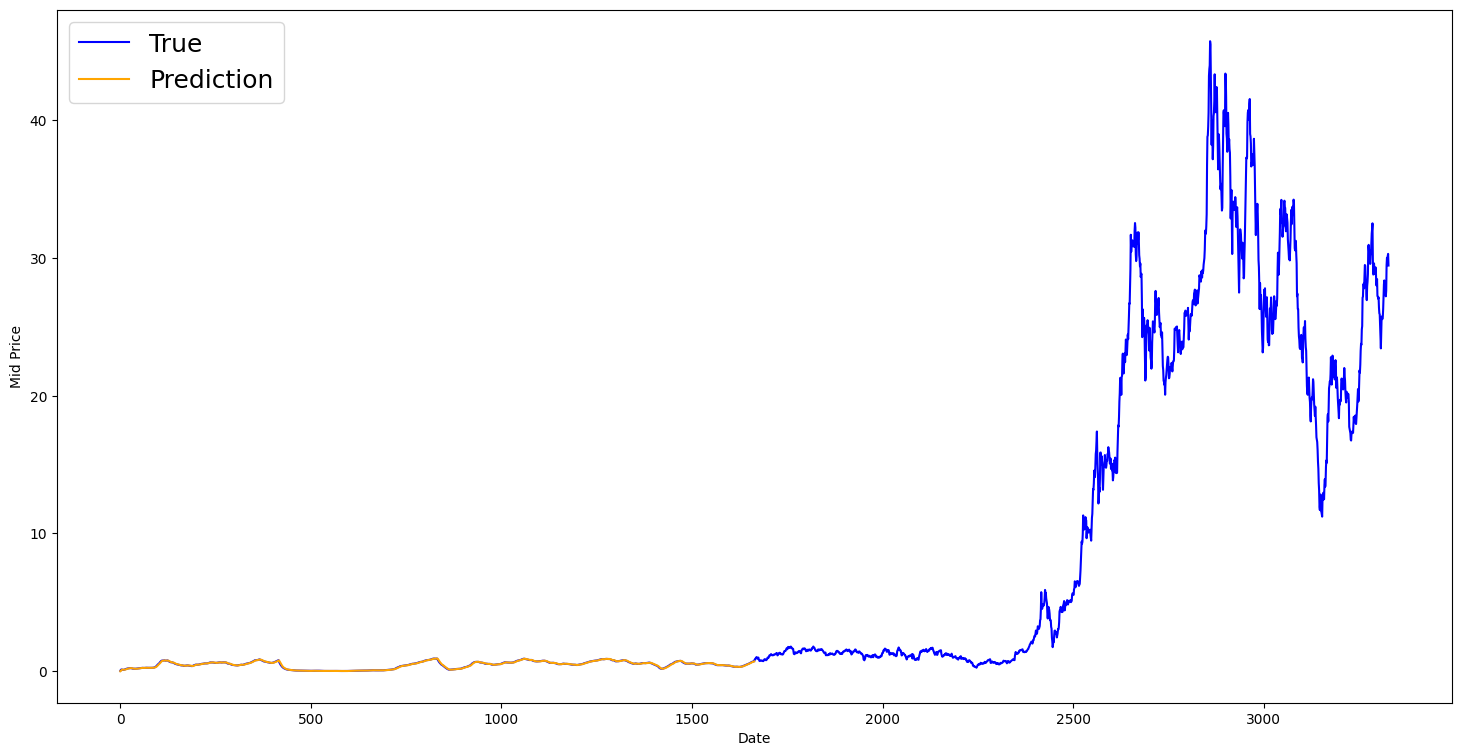

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()